In [21]:
import os
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pandas as pd
import numpy as np

In [3]:
# Set up paths
base_dir = "chest_xray"
folders = ["train", "test", "val"]
classes = ["NORMAL", "PNEUMONIA"]

In [4]:
# Initialize storage
data = []

In [5]:
# Load dataset
for folder in folders:
    for label in classes:
        path = os.path.join(base_dir, folder, label)
        files = os.listdir(path)
        for file in files:
            file_path = os.path.join(path, file)
            data.append({
                "folder": folder,
                "label": label,
                "file_path": file_path
            })


In [6]:
# Convert to DataFrame
df = pd.DataFrame(data)

In [7]:
# EDA tasks
# Class distribution
print(df.groupby(["folder", "label"]).size())

folder  label    
test    NORMAL        234
        PNEUMONIA     390
train   NORMAL       1341
        PNEUMONIA    3875
val     NORMAL          8
        PNEUMONIA       8
dtype: int64


In [26]:
df.head()

,folder,label,file_path,is_corrupted
0,train,NORMAL,chest_xray\train\NORMAL\IM-0115-0001.jpeg,False
1,train,NORMAL,chest_xray\train\NORMAL\IM-0117-0001.jpeg,False
2,train,NORMAL,chest_xray\train\NORMAL\IM-0119-0001.jpeg,False
3,train,NORMAL,chest_xray\train\NORMAL\IM-0122-0001.jpeg,False
4,train,NORMAL,chest_xray\train\NORMAL\IM-0125-0001.jpeg,False


In [9]:
df.shape

(5856, 3)

In [11]:
# Visualize random samples
def show_random_images(df, label, n=5):
    subset = df[df["label"] == label].sample(n)
    fig, ax = plt.subplots(1, n, figsize=(15, 5))
    for i, row in enumerate(subset.iterrows()):
        img = cv2.imread(row[1]["file_path"], cv2.IMREAD_GRAYSCALE)
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.suptitle(f"Random samples of {label}")
    plt.show()


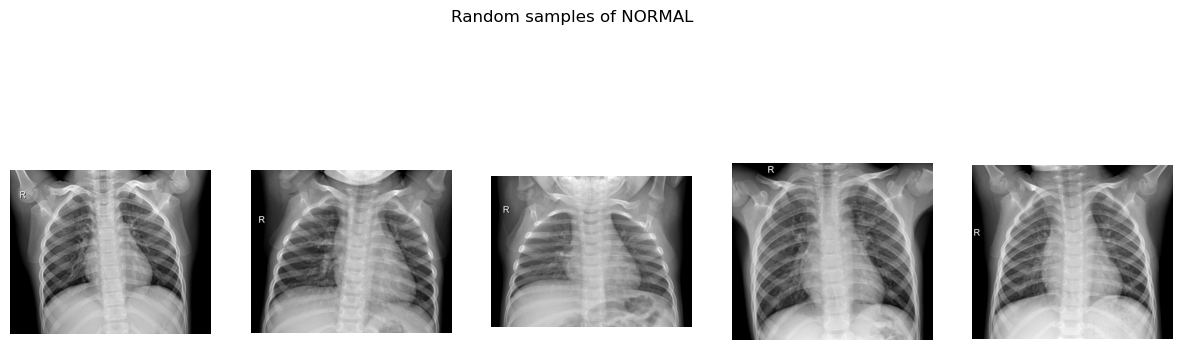

In [12]:
# Call the visualization function
show_random_images(df[df['folder'] == 'train'], 'NORMAL', 5)

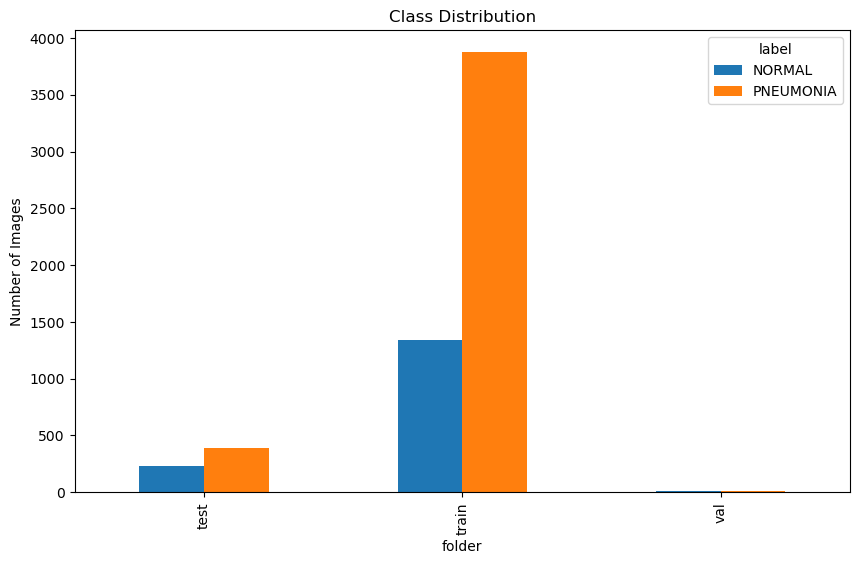

Corrupted files: 25


In [16]:
# Class distribution plot
df.groupby(['folder', 'label']).size().unstack().plot(kind='bar', figsize=(10, 6), title="Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# Check for corrupted images
def is_corrupted(file_path):
    try:
        img = cv2.imread(file_path)
        return img is None
    except:
        return True

df['is_corrupted'] = df['file_path'].apply(is_corrupted)
print(f"Corrupted files: {df['is_corrupted'].sum()}")

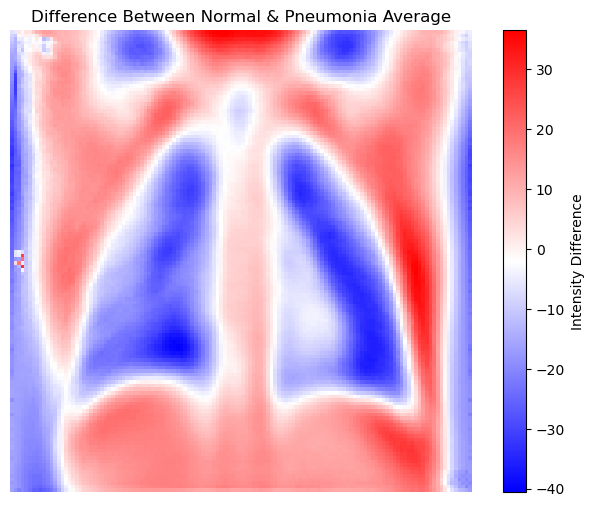

In [22]:

# Function to calculate the average image for a class
def calculate_average_image(df, label, image_size=(128, 128)):
    images = []
    for file_path in df[df['label'] == label]['file_path']:
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, image_size)  # Resize to a fixed size
        images.append(img)
    return np.mean(images, axis=0)

# Calculate average images for NORMAL and PNEUMONIA
norm_mean = calculate_average_image(df[df['folder'] == 'train'], 'NORMAL')
pneu_mean = calculate_average_image(df[df['folder'] == 'train'], 'PNEUMONIA')

# Calculate the contrast between the average images
contrast_mean = norm_mean - pneu_mean

# Visualize the contrast
plt.figure(figsize=(8, 6))
plt.imshow(contrast_mean, cmap='bwr')
plt.title('Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.colorbar(label='Intensity Difference')
plt.show()


### The range of values in the contrast image highlights key differences between the two classes. Negative values (e.g., -40) indicate areas where the average intensity in PNEUMONIA images is significantly higher than in NORMAL images, often corresponding to denser or more prominent features like opacities or infiltrates commonly associated with pneumonia. Conversely, positive values (e.g., +30) represent regions where the average intensity in NORMAL images is higher, reflecting structures or areas that remain clearer in healthy X-rays but appear obscured or altered in pneumonia cases.

In [33]:
# Image dimension distribution
dimensions = []
for file_path in df['file_path']:
    img = cv2.imread(file_path,)
    dimensions.append(img.shape)

dim_df = pd.DataFrame(dimensions, columns=["Height", "Width", "Channels"])
print(dim_df.describe())

            Height        Width  Channels
count  5856.000000  5856.000000    5856.0
mean    970.689037  1327.880806       3.0
std     383.392117   363.500922       0.0
min     127.000000   384.000000       3.0
25%     688.000000  1056.000000       3.0
50%     888.000000  1281.000000       3.0
75%    1187.000000  1560.000000       3.0
max    2713.000000  2916.000000       3.0
